In [ ]:
!pip install transformers datasets torch scikit-learn matplotlib seaborn -q
!pip install transformers

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments


In [ ]:
df = pd.read_csv("Shopee_Sampled_Reviews.csv")

In [ ]:
df = df[['content', 'score']]

In [ ]:
def score_to_sentiment(score):
    if score <= 2:
        return 0   # Negatif
    elif score == 3:
        return 1   # Netral
    else:
        return 2   # Positif

df['label'] = df['score'].apply(score_to_sentiment)

print("Distribusi Label Sentimen:")
print(df['label'].value_counts())

Distribusi Label Sentimen:
label
0    1000
2    1000
1     500
Name: count, dtype: int64


In [ ]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['content'].tolist(), df['label'].tolist(), test_size=0.2, random_state=42
)

In [ ]:
model_name = "indobenchmark/indobert-base-p1"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

train_dataset = Dataset.from_dict({"text": train_texts, "labels": train_labels}).map(tokenize, batched=True)
test_dataset  = Dataset.from_dict({"text": test_texts, "labels": test_labels}).map(tokenize, batched=True)

train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)  # 3 kelas (negatif, netral, positif)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch", # Changed from evaluation_strategy
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,   # bisa dinaikkan kalau butbutuh
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    # Use processing_class instead of tokenizer
    processing_class=tokenizer,
)

In [ ]:
trainer.train()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: abimanyurafi09 (abimanyurafi09-telkom-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss
1,0.793900,0.821239
2,0.667600,0.821255


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=250, training_loss=0.7153972873687744, metrics={'train_runtime': 5480.2803, 'train_samples_per_second': 0.73, 'train_steps_per_second': 0.046, 'total_flos': 263113417728000.0, 'train_loss': 0.7153972873687744, 'epoch': 2.0})

In [ ]:
predictions = trainer.predict(test_dataset)
y_pred = predictions.predictions.argmax(-1)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [ ]:
print("\nClassification Report:")
print(classification_report(test_labels, y_pred, target_names=["Negatif", "Netral", "Positif"]))



Classification Report:
              precision    recall  f1-score   support

     Negatif       0.58      0.88      0.70       188
      Netral       0.33      0.06      0.10       108
     Positif       0.78      0.75      0.77       204

    accuracy                           0.65       500
   macro avg       0.57      0.56      0.52       500
weighted avg       0.61      0.65      0.60       500



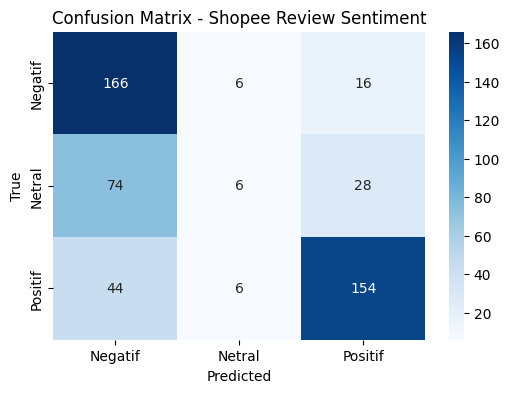

In [ ]:
cm = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negatif", "Netral", "Positif"], yticklabels=["Negatif", "Netral", "Positif"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Shopee Review Sentiment")
plt.show()